In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft

In [2]:
d = 1; c = 3.0*10**8
wp = 2*np.pi*c/(1.03*10**-6); ws = 2/4*wp;  wi = wp-ws; w2i = 2*wi #Frequencies

ns = 2.01; n_p = 2.02; ni = 2; n2i = 2.01 #Indexes of refraction. 
#n_p 2.04

ks = ns*ws/c; kp = n_p*wp/c; ki = ni*wi/c; k2i = n2i*w2i/c
delta_k_OPA = np.abs(kp-ks-ki)#*0
delta_k_SHG = np.abs(k2i-2*ki)#*0

Ks = 1j*ws*d/(ns*c)
Kp = 1j*wp*d/(n_p*c)
Ki = 1j*wi*d/(ni*c)
K2i = 1j*w2i*d/(2*n2i*c)
print(delta_k_OPA)
print(delta_k_SHG)

91502.698648246
61001.79909883067


In [3]:
z_max = 3*10**-2 #3cm
z = np.linspace(0,z_max,10000)
I_s = 2*ns*c*8.9**-12 
I_p = 2*n_p*c*8.9**-12
I_i = 2*ni*c*8.9**-12
I_2i = 2*n2i*c*8.9**-12
As = 0.0001+0.0j; Ap = As*10; Ai = 0.0+0.0j; A2i = 0.0+0.0j #Gain is pretty much the minimum at 10.
y0 = [As, Ap, Ai, A2i]

def RK4(dydx, z, y0):    
    h = (z[1]-z[0])
    h_list = np.full(shape = len(y0), fill_value = h, dtype = float)
    y = np.zeros([len(z+1), len(y0)],dtype = complex)  
    y[0] = y0

    for iters, z_iters in enumerate(tqdm(z,desc=dydx.__name__)):
        k1 = h_list * dydx(z_iters, y[iters], iters)
        k2 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k1, iters)
        k3 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k2, iters)
        k4 = h_list * dydx(z_iters + h, y[iters] + k3, iters)
        
        if iters == len(z)-1:
            break
        y[iters+1] = y[iters] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return y
d_r = np.sin(z*delta_k_OPA)+np.sin(z*delta_k_SHG)
d_eff = np.sign(d_r) #np.full(len(z),fill_value = 1) 

def dAdz(z,S,iters):
    As, Ap, Ai, A2i = S
    return  (d_eff[iters]*Ks*Ap*np.conj(Ai)*np.exp(1j*delta_k_OPA*z), 
            d_eff[iters]*Kp*As*Ai*np.exp(-1j*delta_k_OPA*z), 
            d_eff[iters]*Ki*(Ap*np.conj(As)*np.exp(1j*delta_k_OPA*z)+A2i*np.conj(Ai)*
            np.exp(1j*delta_k_SHG*z)), 
            d_eff[iters]*K2i*Ai**2*np.exp(-1j*delta_k_SHG*z))

y_list = RK4(dAdz, z, y0)
As_list = I_s*(np.abs(y_list[:,0])**2)
Ap_list = I_p*(np.abs(y_list[:,1])**2)
Ai_list = I_i*(np.abs(y_list[:,2])**2)
A2i_list = I_2i*(np.abs(y_list[:,3])**2)
zero = np.full(len(z), fill_value = np.amax(As_list)/np.amax(Ap_list))


dAdz: 100%|█████████▉| 9999/10000 [00:01<00:00, 6351.86it/s]


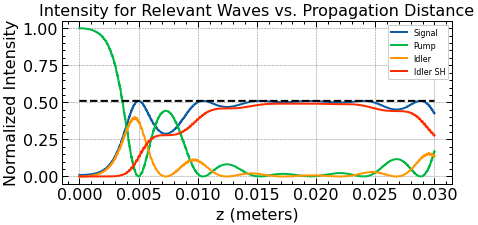

In [4]:
plt.figure(figsize=(7,3))
plt.plot(z,As_list/np.amax(Ap_list))
plt.plot(z,Ap_list/np.amax(Ap_list))
plt.plot(z,Ai_list/np.amax(Ap_list))
plt.plot(z,A2i_list/np.amax(Ap_list))
plt.plot(z,zero,'k--')

plt.xlabel("z (meters)")
plt.ylabel("Normalized Intensity")
plt.legend(["Signal", "Pump", "Idler", "Idler SH"],prop={'size': 8})
plt.title("Intensity for Relevant Waves vs. Propagation Distance")
#plt.savefig('Graph SHG.png', bbox_inches='tight')
plt.show()

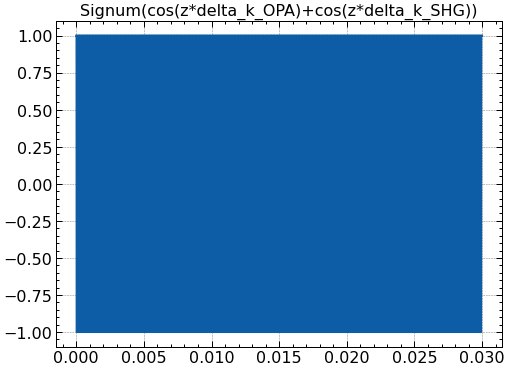

In [5]:
plt.plot(z,np.sign(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG)))
plt.title("Signum(cos(z*delta_k_OPA)+cos(z*delta_k_SHG))")
plt.show()

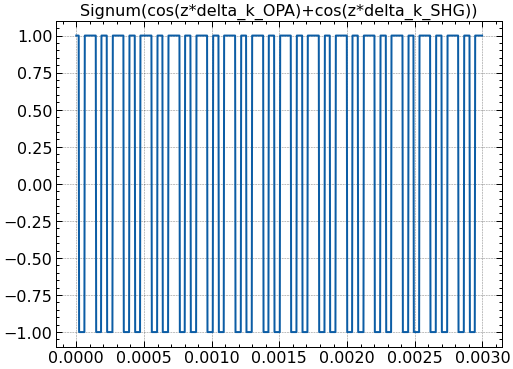

In [6]:
plt.plot(z[:1000],np.sign(np.cos(z[:1000]*delta_k_OPA)+np.cos(z[:1000]*delta_k_SHG)))
plt.title("Signum(cos(z*delta_k_OPA)+cos(z*delta_k_SHG))")
plt.show()

In [7]:
timestep = z_max/20000
r1 = fft(d_eff)
n1 = r1.size

freq1 = fftfreq(n1, timestep)*np.pi

r2 = fft(d_r)
n2 = r2.size

freq2 = fftfreq(n2, timestep)*np.pi


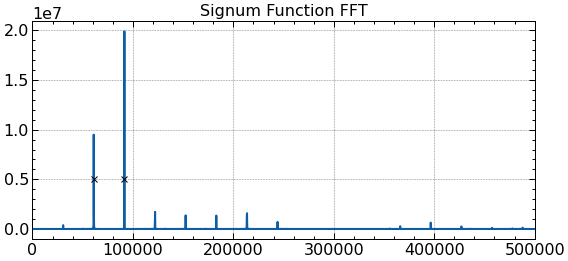

9496367.619770277
19894919.345286626
Ratio of FFT Squared (OPA/SHG) is 2.0950030729505285... So ratio is 1.4474125441457693


In [8]:
plt.figure(figsize=(9,4))
plt.plot(freq1,np.abs(r1)**2)
plt.plot(delta_k_OPA,0.5*10**7,'kx') 
plt.plot(delta_k_SHG,0.5*10**7,'kx') 
plt.xlim(0,0.5*10**6)
plt.title('Signum Function FFT')
plt.show()
b1 = np.abs(r1)**2

max1 = np.amax(b1[0:math.ceil(20000/500000*10000)])
max2 = np.amax(b1[math.ceil(20000/500000*10000):math.ceil(40000/500000*10000)])
print(max1)
print(max2)
print("Ratio of FFT Squared (OPA/SHG) is "+str(max2/max1)+"... So ratio is "+ str((max2/max1)**0.5))

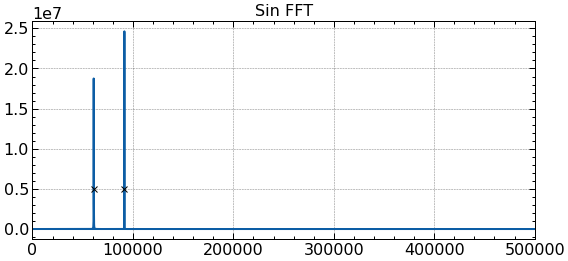

18753957.444483735
24627341.61453748
Ratio of FFT Squared (OPA/SHG) is 1.3131810545822336... So ratio is 1.14594112177818


In [9]:
plt.figure(figsize=(9,4))
plt.plot(freq2,np.abs(r2)**2)
plt.plot(delta_k_OPA,0.5*10**7,'kx') 
plt.plot(delta_k_SHG,0.5*10**7,'kx') 
plt.xlim(0,0.5*10**6)
plt.title('Sin FFT')
plt.show()
b2 = np.abs(r2)**2

max1 = np.amax(b2[0:math.ceil(20000/500000*10000)])
max2 = np.amax(b2[math.ceil(20000/500000*10000):math.ceil(100000/500000*10000)])
print(max1)
print(max2)
print("Ratio of FFT Squared (OPA/SHG) is "+str(max2/max1)+"... So ratio is "+ str((max2/max1)**0.5))

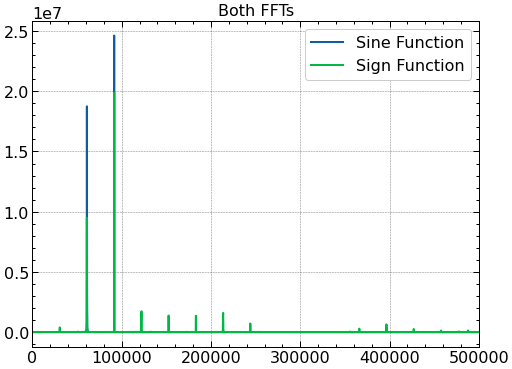

In [10]:

plt.plot(freq2,np.abs(r2)**2)
plt.plot(freq1,np.abs(r1)**2)
plt.xlim(0,0.5*10**6)
plt.title("Both FFTs")
plt.legend(["Sine Function","Sign Function"])
#plt.savefig('FFTSHG.png', bbox_inches='tight')
plt.show()

## References:

[1]: Boyd, Robert W. Nonlinear Optics. San Diego, CA: Academic Press, 2003. Print.

[2]: Jeffrey Moses, Noah Flemens, and Xiaoyue Ding "Back-conversion suppressed parametric frequency conversion for ultrawide bandwidth and ultrahigh efficiency devices", Proc. SPIE 11264, Nonlinear Frequency Generation and Conversion: Materials and Devices XIX, 112640B (2 March 2020); https://doi.org/10.1117/12.2548361

[3]: Andrew H. Norton and C. Martijn de Sterke, "Aperiodic 1-dimensional structures for quasi-phase matching," Opt. Express 12, 841-846 (2004)